# Select fCpGs

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress, spearmanr, ttest_ind
from math import ceil
import MolecularClocks.src.methylation_util as m_util
from MolecularClocks.src.merge_pdfs import merge_pdfs
from MolecularClocks.src.invasiveCpGs_consts import getConsts
# from expandAnnotations import expand
import util as local_util

consts = getConsts()

sns.set(rc={"savefig.bbox":'tight'}, font_scale=1.2)

In [2]:
neutral_DNA_CpG_list = local_util.getNeutralDNACpGs()
data = local_util.getDataDict()

Starting with 646 tumors
Removing 4 tumors for not being from unique patients
Removing 1 tumors for not having a purity estimate


In [3]:
figure_outdir = 'figures'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

## Generalizability/Sensitivity Tests

In [3]:
# Test generalizability of the method
# Pick 1000 most variable sites and divide them in half randomly
# Calculate c_beta for each tumor using each set of sites
# Calculate correlation between the two c_beta values for each tumor

balanced_CpGs_only_ductals = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=True)
balanced_CpGs_all_tumors = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=False)

c_beta_only_ductals = 1 - data['tumor']['beta_values_PURE'].loc[balanced_CpGs_only_ductals].std(axis=0)
c_beta_all_tumors = 1 - data['tumor']['beta_values_PURE'].loc[balanced_CpGs_all_tumors].std(axis=0)

print(f'{np.intersect1d(balanced_CpGs_only_ductals, balanced_CpGs_all_tumors).shape[0]} sites shared')
print(f'r = {linregress(c_beta_only_ductals, c_beta_all_tumors).rvalue}')

462 sites shared
r = 0.9976461891254752


In [3]:
# Test sensitivity of the sites
# Pick 1000 most variable sites and divide them in half randomly
# Calculate c_beta for each tumor using each set of sites
# Calculate correlation between the two c_beta values for each tumor

balanced_CpGs_all_tumors = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=False)

balanced_CpGs_all_tumors_1000 = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=False, n_select=1000)
np.random.shuffle(balanced_CpGs_all_tumors_1000)

rand_split_1 = balanced_CpGs_all_tumors_1000[:500]
rand_split_2 = balanced_CpGs_all_tumors_1000[500:]

c_beta_all_tumors = 1 - data['tumor']['beta_values_PURE'].loc[balanced_CpGs_all_tumors].std(axis=0)
c_beta_rand_split_1 = 1 - data['tumor']['beta_values_PURE'].loc[rand_split_1].std(axis=0)
c_beta_rand_split_2 = 1 - data['tumor']['beta_values_PURE'].loc[rand_split_2].std(axis=0)

print(f'{np.intersect1d(rand_split_1, balanced_CpGs_all_tumors).shape[0]} original sites in rand split 1')
print(f'{np.intersect1d(rand_split_2, balanced_CpGs_all_tumors).shape[0]} original sites in rand split 2')

print(f'r = {linregress(c_beta_rand_split_1, c_beta_rand_split_2).rvalue}')

256 original sites in rand split 1
244 original sites in rand split 2
r = 0.9685833485738136


## Select 500 CpGs

In [4]:
balanced_CpGs_final_set = local_util.gen_CpG_set(data, neutral_DNA_CpG_list, only_ductals=False)
np.savetxt('balanced_CpGs_all_tumors.txt', balanced_CpGs_all_tumors, fmt='%s')

## Visualization of Site Selection

/var/folders/7j/2z93zxs52qn4yjl8szt8gys80000hf/T/ipykernel_11296/2416974038.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cutoff = data['tumor']['beta_stds'].loc[balanced_means_CpGs].sort_values()[-500]


NameError: name 'image_outdir' is not defined

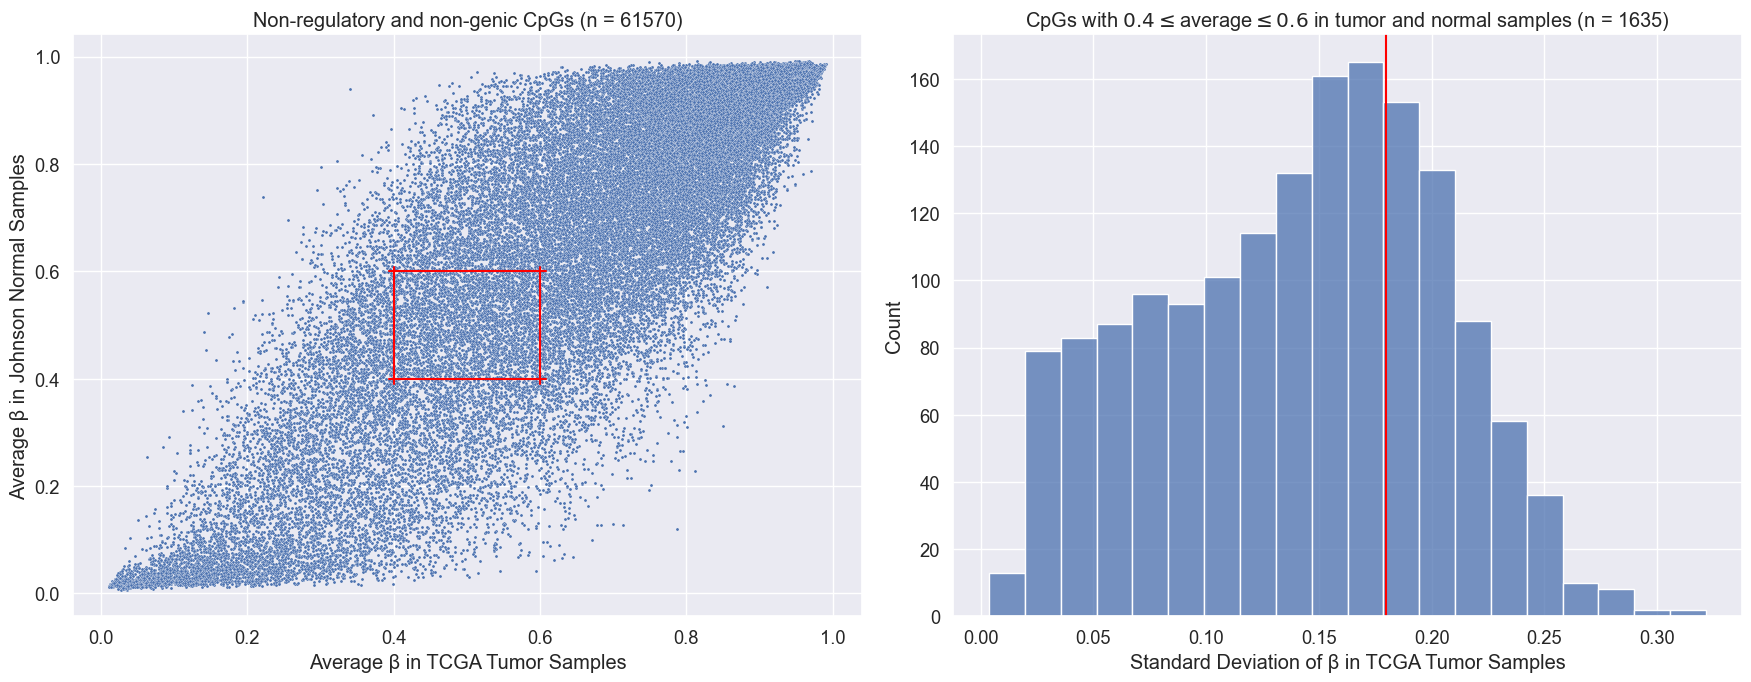

In [4]:
# Add beta_means, beta_stds, beta_nans to data dict
local_util.addMeanStdsNans(data)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.tight_layout(pad=2)

sns.scatterplot(ax=axes[0], x=data['tumor']['beta_means'].loc[neutral_DNA_CpG_list],
                y=data['normal']['beta_means'].loc[neutral_DNA_CpG_list], s=5)
axes[0].set_xlabel('Average β in TCGA Tumor Samples')
axes[0].set_ylabel('Average β in Johnson Normal Samples')
axes[0].set_title(f'Non-regulatory and non-genic CpGs (n = {len(neutral_DNA_CpG_list)})')

lower = 0.4
upper = 0.6
color = 'red'

axes[0].axvline(lower, lower, upper, color=color)
axes[0].axvline(upper, lower, upper, color=color)
axes[0].axhline(lower, lower, upper, color=color)
axes[0].axhline(upper, lower, upper, color=color)

balanced_means_CpGs = m_util.getCpG_list(data, local_util.BALANCED_CRITERIA, starting_CpG_list=neutral_DNA_CpG_list)

sns.histplot(ax=axes[1], x=data['tumor']['beta_stds'].loc[balanced_means_CpGs])
axes[1].set_xlabel('Standard Deviation of β in TCGA Tumor Samples')
axes[1].set_title(f'CpGs with $0.4 \leq $average$\leq 0.6$ in tumor and normal samples (n = {len(balanced_means_CpGs)})')

cutoff = data['tumor']['beta_stds'].loc[balanced_means_CpGs].sort_values()[-500]
axes[1].axvline(cutoff, color=color)

fig.savefig(os.path.join(image_outdir, 'initial_selection.pdf'), format='pdf', pad_inches=0.1)